<IPython.core.display.Javascript object>


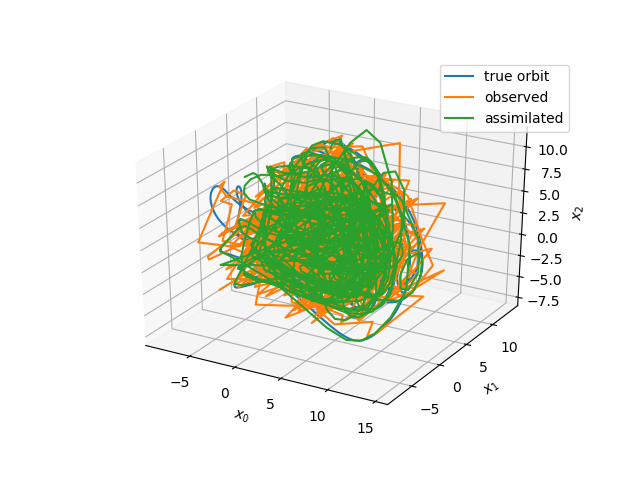

<IPython.core.display.Javascript object>


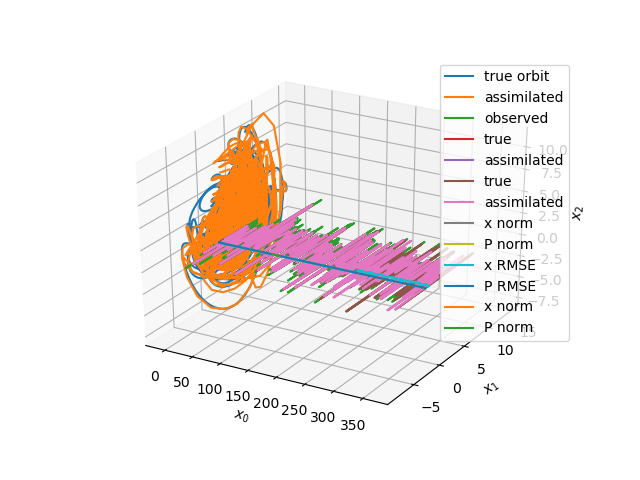

RMSE:  0.634859833908


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 14 17:01:40 2017

@author: yk
"""

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import math

def handler(func, *args):
    return func(*args)

#%%
class Lorenz96:
    def __init__(self, N, F):
        self.N = N
        self.F = F
        
    def gradient(self,t,x):
        d = np.zeros(self.N)
        d[0] = (x[1] - x[self.N-2]) * x[self.N-1] - x[0]
        d[1] = (x[2] - x[self.N-1]) * x[0]- x[1]
        d[self.N-1] = (x[0] - x[self.N-3]) * x[self.N-2] - x[self.N-1]
        for i in range(2, self.N-1):
            d[i] = (x[i+1] - x[i-2]) * x[i-1] - x[i]
        return d + self.F    

    def jacobian(self, x):
        m = np.zeros((self.N,self.N))
        for i in range(self.N):
            for j in range(self.N):
                if (((i-1) % self.N) == (j % self.N)):
                    m[i][j] += x[(i+1) % self.N] - x[(i-2) % self.N]
                if (((i+1) % self.N) == (j % self.N)):
                    m[i][j] += x[(i-1) % self.N]
                if (((i-2) % self.N) == (j % self.N)):
                    m[i][j] -= x[(i-1) % self.N]
                if ((i     % self.N) == (j % self.N)):
                    m[i][j] -= 1
        return m
        
    
class RK4:
    def __init__(self, N, dt):
        self.N = N
        self.dt = dt

    def nextstep(self, gradient, t, x):
        k1 = handler(gradient, t, x)
        k2 = handler(gradient, t + self.dt/2, x + k1*self.dt/2)
        k3 = handler(gradient, t + self.dt/2, x + k2*self.dt/2)
        k4 = handler(gradient, t + self.dt  , x + k3*self.dt)
        return x + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6
    
    def orbit(self, gradient, t0, x0, T):
        t = np.arange(0., T, dt)
        steps = int(T/self.dt)
        o = np.zeros((steps,self.N))
        o[0] = np.copy(x0)
        for i in range(1,steps):
            o[i] = self.nextstep(gradient, t[i], o[i-1])
        return o

    def observed(self, gradient, t0, x0, T, stddev):
        steps = int(T/self.dt)
        o = self.orbit(gradient, t0, x0, T)
        for i in range(steps):
            o[i] += stddev * np.random.randn()
        return o


class RK4Matrix:
    def __init__(self, M, N, dt):
        self.M = M
        self.N = N
        self.dt = dt
        
    def nextstep(self, gradient, t, x, pa):
        k1 = handler(gradient, t, x, pa)
        k2 = handler(gradient, t + self.dt/2, x + k1*self.dt/2, pa)
        k3 = handler(gradient, t + self.dt/2, x + k2*self.dt/2, pa)
        k4 = handler(gradient, t + self.dt  , x + k3*self.dt, pa)
        return x + (k1 + 2*k2 + 2*k3 + k4) * self.dt/6            

    
class KFstep:
    def __init__(self, model, intmodelx, intmodelP, N, dt, R, P0):
        self.model = model
        self.intmodelx = intmodelx
        self.intmodelP = intmodelP
        self.N = N
        self.dt = dt
        self.R = R
        self.P0 = P0

    def errorCovGrad(self, t, P, x):
        M = self.model.jacobian(x)
        return M @ P + P @ np.transpose(M)

    def predict(self, xa, Pa, t):
        xf = self.intmodelx.nextstep(self.model.gradient, t, xa)
        Pf = 1.009 * self.intmodelP.nextstep(self.errorCovGrad, t, Pa, xa) # tuning: increase Pf
#        if np.sum(Pf) > 100:
#            Pf = np.copy(self.P0)
        return xf, Pf
        
    def update(self, xf, Pf, y):
        innov = y - xf
#        print("Innov", innov)
        InnovCov = self.R + Pf
        Gain = Pf @ np.linalg.inv(InnovCov)
#        print ("Gain", Gain)
        xa = xf + Gain @ innov
#        Pa = Pf - Gain @ InnovCov @ np.transpose(Gain)
        Pa = Pf - Gain @ Pf
        return xa, Pa
        
    def step(self, xa, Pa, y, t, it):
        for i in range(it):
            xa, Pa = self.predict(xa, Pa, t) # LHS means xf, Pf
        return self.update(xa, Pa, y) # RHS means xf, Pf
    
    
class KF:
    def __init__(self, kfstep, T, dt, xf, Pf, xa, Pa, y, it):
        self.kfstep = kfstep
        self.xf = xf
        self.Pf = Pf
        self.xa = xa
        self.Pa = Pa
        self.y = y
        self.it = it
        self.steps = int(T/dt/it)
        
    def filtering(self):
        t = np.arange(0., T, dt)
        k = 0
        self.xa[0], self.Pa[0] = self.kfstep.update(self.xf[0], self.Pf[0], y[0])
        for i in range(1, self.steps):
            self.xf[k+1], self.Pf[k+1] = self.kfstep.predict(self.xa[i-1], self.Pa[i-1], t[k])
            k += 1
            for j in range(1, self.it):
                self.xf[k+1], self.Pf[k+1] = self.kfstep.predict(self.xf[k], self.Pf[k], t[k])
                k += 1
            self.xa[i], self.Pa[i] = self.kfstep.update(self.xf[k], self.Pf[k], y[i])
        return self.xf, self.Pf, self.xa, self.Pa

def plot_orbit(dat):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat[:,0],dat[:,1],dat[:,2])
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.show()

def compare_orbit(dat1, dat2):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label='true orbit')
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label='assimilated')
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

def compare_orbit3(dat1, dat2, dat3, label1, label2, label3):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(dat1[:,0],dat1[:,1],dat1[:,2],label=label1)
    ax.plot(dat2[:,0],dat2[:,1],dat2[:,2],label=label2)
    ax.plot(dat3[:,0],dat3[:,1],dat3[:,2],label=label3)
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.set_zlabel('$x_2$')
    plt.legend()
    plt.show()

#%%
N = 40
F = 8
year = 1
day = 365 * year
dt = 0.01
T = day * 0.2
it = 5
minute_steps = int(T/dt)
steps = int(minute_steps/it)
stddev = 1

true_orbit = np.loadtxt("data/year.1.dat")

y = np.loadtxt("data/observed6h.1.dat")

R = np.zeros((N, N))
np.fill_diagonal(R, 1)

lorenz = Lorenz96(N, F)
rk4 = RK4(N, dt)
rk4matrix = RK4Matrix(N, N, dt)

t = np.arange(0., T, dt)
t_day = np.copy(t)/0.2
t_day_every6h = []
for i in range(0,minute_steps,it):
    t_day_every6h.append(t_day[i])

xf = np.zeros((minute_steps, N))
xf[0] = np.loadtxt("data/assimilation_xzero.2.dat")

xa = np.zeros((steps, N))

Pf = np.zeros((minute_steps, N, N))
Pf[0] = np.loadtxt("data/cov.1.dat")

Pa = np.zeros((steps, N, N))

kfstep = KFstep(lorenz, rk4, rk4matrix, N, dt, R, Pf[0])
#kf = KF(kfstep, T, dt, x, P, y, it)
# short term
kf = KF(kfstep, T, dt, xf, Pf, xa, Pa, y, it)

kf.filtering()

compare_orbit3(true_orbit[0:len(t)], y[0:int(len(t)/it)], kf.xa[0:int(len(t)/it)], 'true orbit', 'observed', 'assimilated')
compare_orbit(true_orbit[0:len(t)], kf.xa[0:int(len(t)/it)])

for j in range(1):
#for j in range(N):
    plt.plot(t_day_every6h,[item[j] for item in y[0:int(len(t)/it)]], label='observed')
    plt.plot(t_day,[item[j] for item in true_orbit[0:len(t)]], label='true')
    plt.plot(t_day_every6h,[item[j] for item in kf.xa[0:int(len(t)/it)]], label='assimilated')
    plt.legend()
    plt.show()
#%%
for j in range(1):
#for j in range(N):
    plt.plot(t_day,[item[j] for item in true_orbit[0:len(t)]], label='true')
    plt.plot(t_day_every6h,[item[j] for item in kf.xa[0:int(len(t)/it)]], label='assimilated')
    plt.legend()
    plt.show()

#%%
plt.plot(t_day_every6h, [np.linalg.norm(xa[i] - true_orbit[i*it])/N for i in range(int(len(t)/it))], label='x norm')
plt.plot(t_day_every6h, [np.linalg.norm(Pa[i])/N for i in range(int(len(t)/it))], label='P norm')
plt.legend()
plt.show()

print ("RMSE: ", np.mean([np.linalg.norm(xa[i] - true_orbit[i*it])/N for i in range(1000,(int(len(t)/it)))]))
#%%
x = np.copy(xf)
for i in range(steps):
    x[it*i] = xa[i]

P = np.copy(Pf)
for i in range(steps):
    P[it*i] = Pa[i]
#%%
plt.plot(t_day, [np.linalg.norm(x[i] - true_orbit[i])/N for i in range(len(t))], label='x RMSE')
plt.plot(t_day, [np.linalg.norm(P[i])/N for i in range(len(t))], label='P RMSE')
plt.legend()
plt.show()

#%%
plt.plot([i for i in range(99,111)], [np.linalg.norm(x[i] - true_orbit[i])/N for i in range(99,111)], label='x norm')
plt.plot([i for i in range(99,111)], [np.linalg.norm(P[i])/N for i in range(99,111)], label='P norm')
plt.legend()
plt.show()